In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from collections import defaultdict
import seaborn as sns
%matplotlib inline

In [31]:
### Global variables
ROOT = "/users/kcochran/projects/domain_adaptation_nosexchr/"

tfs = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
tfs_latex_names = {"CTCF" : "CTCF",
                   "CEBPA" : "CEBPA",
                   "Hnf4a" : "HNF4A",
                   "RXRA" : "RXRA"}

all_trainspecies = ["mm10", "hg38"]
model_names_dict = {"mm10" : "Mouse", "hg38" : "Human"}


REPEAT_TYPES = ["Alu",
"AluJb",
"AluJo",
"AluJr",
"AluJr4",
"AluSc",
"AluSc5",
"AluSc8",
"AluSg",
"AluSg4",
"AluSg7",
"AluSp",
"AluSq",
"AluSq10",
"AluSq2",
"AluSq4",
"AluSx",
"AluSx1",
"AluSx3",
"AluSx4",
"AluSz",
"AluSz6",
"AluY",
"AluYa5",
"AluYa8",  # < 100 instances in test set
"AluYb8",
"AluYb9",  # < 100 instances in test set
"AluYc",
"AluYc3",
"AluYd8",
"AluYe5",
"AluYe6",
"AluYf1",
"AluYg6",
"AluYh3",
"AluYh3a3",
"AluYh7",
"AluYh9",
"AluYi6",
"AluYi6_4d",
"AluYj4",
"AluYk",
"AluYk11",
"AluYk12",  # < 100 instances in test set
"AluYk2",
"AluYk3",
"AluYk4",
"AluYm1"]

# Load Predictions and Labels

In [3]:
def get_preds_file(tf, train_species, test_species):
    # this file is created by the 0_generate_predictions notebook
    return ROOT + "/model_out/" + tf + "_" + train_species + "-trained_" + test_species + "-test.preds.npy"


def load_average_test_set_preds(test_species):
    # takes a while to run.
    preds_dict = defaultdict(lambda : dict())

    # loop over mouse-trained, human-trained models, and DA mouse-trained models
    for train_species in all_trainspecies:
        for tf in tfs:
            print("=== " + tf + ", " + train_species + "-trained ===")

            # load predictions for all 5 independent model runs
            preds_file = get_preds_file(tf, train_species, test_species)
            try:
                preds_dict[train_species][tf] = np.mean(np.load(preds_file), axis = 1)
            except:
                print("Could not load preds file:", preds_file)
            
    return preds_dict


avg_preds_human_test = load_average_test_set_preds("hg38")

=== CTCF, mm10-trained ===
=== CEBPA, mm10-trained ===
=== Hnf4a, mm10-trained ===
=== RXRA, mm10-trained ===
=== CTCF, hg38-trained ===
=== CEBPA, hg38-trained ===
=== Hnf4a, hg38-trained ===
=== RXRA, hg38-trained ===


In [4]:
def get_test_bed_file(tf, species):
    # should be in BED file format
    # this file is specific to each tf -- the last column
    # should contain the binding label for each window
    return(ROOT + "data/" + species + "/" + tf + "/chr2.bed")


def get_test_labels(tf, species = "hg38"):
    # This function reads in the test-data bed file 
    # for a given species and TF and returns the binding labels
    # for each example in that file.
    labels_file = get_test_bed_file(tf, species)
    with open(labels_file) as f:
        return np.array([int(line.split()[-1]) for line in f])

    
def get_all_test_labels_and_indices(preds_dict, species = "hg38"):
    labels = dict()
    bound_indices = dict()
    for tf in tfs:
        # load binding labels from bed file
        labels_for_tf = get_test_labels(tf)
        # assuming the mm10 entry exists, species doesn't matter here
        # shape of preds array should be the same in all cases
        len_to_truncate_by = preds_dict["mm10"][tf].shape[0]
        # truncate binding labels to be multiple of batch size, like preds
        labels[tf] = labels_for_tf[:len_to_truncate_by]
        # get indices where label is bound
        bound_indices[tf] = np.nonzero(labels[tf])[0]
    return labels, bound_indices


labels, bound_indices = get_all_test_labels_and_indices(avg_preds_human_test)

# Find FPs, FNs, etc.

In [5]:
def get_fp_fn_indices(preds_dict, bound_indices):
    #tp_indices = defaultdict(lambda : defaultdict(lambda : []))  # not needed for now
    fp_indices = defaultdict(lambda : defaultdict(lambda : []))
    fn_indices = defaultdict(lambda : defaultdict(lambda : []))

    for tf in tfs:
        for train_species in all_trainspecies:
            print(tf, train_species)
            # using a threshold of 0.5 here to decide what is predicted as bound
            predicted_as_bound_indices = np.nonzero(preds_dict[train_species][tf] > 0.5)[0]

            for index in predicted_as_bound_indices:
                if not index in bound_indices[tf]:
                    fp_indices[tf][train_species].append(index)
                #else:
                #    tp_indices[tf][train_species].append(index)
            for index in bound_indices[tf]:
                if index not in predicted_as_bound_indices:
                    fn_indices[tf][train_species].append(index)
            
    return fp_indices, fn_indices


def get_site_indices(preds_dict, bound_indices):
    # This function uses the predictions and binding labels for
    # all sites in the test set to determine if sites are
    # both-model false positives, false negatives, mouse-model FPs, etc.
    
    # Here we use a definition of "differentially predicted site"
    # to find mouse-model FPs or FNs that requires the difference
    # between the mouse-model prediction and the human-model prediction
    # to be at least 0.5
    fp_indices, fn_indices = get_fp_fn_indices(preds_dict, bound_indices)
    
    site_indices = defaultdict(lambda : dict())

    for tf in tfs:
        site_indices[tf]["bothFP"] = set(fp_indices[tf]["mm10"]).intersection(set(fp_indices[tf]["hg38"]))
        site_indices[tf]["bothFN"] = set(fn_indices[tf]["mm10"]).intersection(set(fn_indices[tf]["hg38"]))

        diff_pred_mm10_overpred = set(np.nonzero(preds_dict["mm10"][tf] - preds_dict["hg38"][tf] > 0.5)[0])
        diff_pred_mm10_underpred = set(np.nonzero(preds_dict["hg38"][tf] - preds_dict["mm10"][tf] > 0.5)[0])

        site_indices[tf]["mFP"] = set(fp_indices[tf]["mm10"]).intersection(diff_pred_mm10_overpred)
        site_indices[tf]["mFN"] = set(fn_indices[tf]["mm10"]).intersection(diff_pred_mm10_underpred)
        
    return site_indices


site_subset_indices = get_site_indices(avg_preds_human_test, bound_indices)

CTCF mm10
CTCF hg38
CEBPA mm10
CEBPA hg38
Hnf4a mm10
Hnf4a hg38
RXRA mm10
RXRA hg38


# Load Repeat Annotation Labels

In [45]:
def get_rmsk_file():
    # this file is downloaded by an earlier script
    return ROOT + "data/hg38/rmsk.bed"


def read_and_filter_rmsk_file(repeat_name, test_chrom = "chr2"):
    # This function reads in the RepeatMasker bed file,
    # filters for only rows listing annotations of one
    # repeat type, and then returns only the start and 
    # end coordinate for each annotation.
    
    # We're assuming all the test set examples are on
    # one chromosome, so we don't need the first column.
    
    # assuming bed format
    filename = get_rmsk_file()
    df = pd.read_csv(filename, sep = "\t", usecols = [5, 6, 7, 10, 12], header = None)

    if repeat_name is not "Alu":
        # checking if the prefix of the repeat name matches
        df = df[df[10].str.startswith(repeat_name)]
    else:
        df = df[df[12].str.startswith(repeat_name)]
    
    df = df[df[5] == test_chrom]

    sorted_repeat_coords = sorted(list(zip(df[6], df[7])), key = lambda tup : tup[0])
    return np.array(sorted_repeat_coords)


def get_repeat_and_test_set_overlap(list_a, list_b):
    # This function is similar to bedtools intersect,
    # but returns a binary yes/no for overlap for each
    # window in list_a.
    
    # Assumes everything's on the same chromosome
    # Assumes inputs are lists of 2-ples: (start, stop) 
    
    # output is list with len == len(list_a)
    matches = []
    b_index = 0
    for a_item in list_a:
        a_start, a_end = a_item
        while True:
            if b_index >= len(list_b):
                matches.append(False)
                break
                
            b_start, b_end = list_b[b_index]
            # the -1 is because bed files are 1-indexed
            if b_start > a_end - 1:  
                matches.append(False)
                break
            elif b_end <= a_start:
                b_index += 1
            else:
                matches.append(True)
                break
    assert len(matches) == len(list_a)
    return np.array(matches)


def get_test_bed_coords(species = "hg38"):
    # This function loads in the bed file for the test set
    # and keeps only the start and end coords for each entry.
    # Here we assume the test set is 1 chromosome
    
    # later analysis will assume the coords are sorted,
    # as in `sort -k1,1 -k2,2n $bed_file`
    
    # TF doesn't matter here because we're not using labels
    test_bed_file = get_test_bed_file(tfs[0], species)
    df = pd.read_csv(test_bed_file, sep = "\t", usecols = [1, 2], header = None)
    return df.to_numpy()


def get_all_repeat_labels_and_indices():
    all_windows_coords = get_test_bed_coords()
    repeat_labels = dict()
    repeat_indices = dict()

    for repeat_type in REPEAT_TYPES:
        repeat_type_coords = read_and_filter_rmsk_file(repeat_type)
        
        # filtering for Alu subfamilies with at least 100 instances
        # in the test set, so we don't get incorrectly extreme results
        labels_tmp = get_repeat_and_test_set_overlap(all_windows_coords, repeat_type_coords)
        
        if sum(labels_tmp) > 500:
            print(repeat_type, sum(labels_tmp))
            repeat_labels[repeat_type] = labels_tmp
            repeat_indices[repeat_type] = set(np.nonzero(labels_tmp)[0])
        else:
            print(repeat_type, sum(labels_tmp), "removed")
        
    return repeat_labels, repeat_indices


repeat_labels, repeat_indices = get_all_repeat_labels_and_indices()

Alu 922821
AluJb 124512
AluJo 69859
AluJr 96265
AluJr4 20514
AluSc 57431
AluSc5 6267
AluSc8 19917
AluSg 46076
AluSg4 6911
AluSg7 7205
AluSp 41226
AluSq 77155
AluSq10 1752
AluSq2 56896
AluSq4 1565
AluSx 247237
AluSx1 106517
AluSx3 29914
AluSx4 10256
AluSz 145114
AluSz6 47621
AluY 98776
AluYa5 1840
AluYb8 1221
AluYb9 127 removed
AluYc 4014
AluYc3 370 removed
AluYd8 168 removed
AluYe5 956
AluYe6 158 removed
AluYf1 1472
AluYg6 423 removed
AluYh3 2417
AluYh3a3 225 removed
AluYh7 102 removed
AluYh9 119 removed
AluYi6 394 removed
AluYi6_4d 140 removed
AluYj4 2830
AluYk 2864
AluYk11 771
AluYk2 481 removed
AluYk3 811
AluYk4 726
AluYm1 3412


In [47]:
def calc_repeat_fracs_from_site_overlap(bound_indices, labels, site_subset_indices, repeat_indices):
    # This function calculates what fraction of sites are overlapping a given repeat type,
    # for various categories of sites. The output is returned in nested dictionaries, one
    # for each TF, because the site categorizations are specific to the TF.
    
    repeat_fracs = defaultdict(lambda : dict())

    for tf in tfs:
        # Bound site repeat fraction = (# bound sites overlapping repeat) / (# bound sites)
        num_bound_sites_with_repeat = len(set(bound_indices[tf]).intersection(repeat_indices))
        repeat_fracs[tf]["bound"] = num_bound_sites_with_repeat / len(bound_indices[tf])
        
        # this arithmetic reverses binary-numeric labels (0 is now 1, 1 is now 0)
        num_unbound_sites = sum(labels[tf] * -1 + 1)
        
        # Unbound site repeat fraction = (# unbound sites overlapping repeat) / (# unbound sites)
        # where (# unbound sites overlapping repeat) = (# repeat-overlap sites in test set not in bound site set)
        num_unbound_sites_with_repeat = len(repeat_indices.difference(set(bound_indices[tf])))
        repeat_fracs[tf]["unbound"] = num_unbound_sites_with_repeat / num_unbound_sites

        # for each of the specific categories of sites we're interested in...
        # (e.g. "false positives", "mouse-model false negatives")
        for site_type in site_subset_indices[tf].keys():
            # calc total # of sites in this category
            num_sites = len(site_subset_indices[tf][site_type])
            if num_sites > 0:
                # calc # of sites in this category that overlap the given repeat type
                num_sites_with_repeat = len(site_subset_indices[tf][site_type].intersection(repeat_indices))
                # finally, calc fraction of sites in this category that overlap the repeat type
                repeat_fracs[tf][site_type] = num_sites_with_repeat / num_sites
            else:
                repeat_fracs[tf][site_type] = np.nan
            
    return repeat_fracs


def generate_all_repeat_fracs_for_table(bound_indices, labels, site_subset_indices, repeat_indices):     
    # This function creates the dictionary needed for the print_full_table() function below,
    # where each key is a repeat type and the value is nested dictionaries of the fraction
    # of sites overlapping that repeat type for a given TF (since sets of sites, such as
    # "bound site" and "mouse-model false positive", are different for each TF).
    repeat_fracs = dict()

    for repeat_type in repeat_indices.keys():
        repeat_fracs[repeat_type] = calc_repeat_fracs_from_site_overlap(bound_indices, labels,
                                                                        site_subset_indices,
                                                                        repeat_indices[repeat_type])
    return repeat_fracs



all_repeat_fracs = generate_all_repeat_fracs_for_table(bound_indices, labels,
                                                       site_subset_indices,
                                                       repeat_indices)

In [104]:
def min_max_normalize_list(a_list):
    min_of_list = min(a_list)
    range_of_list = max(a_list) - min_of_list
    return [(num - min_of_list) / range_of_list for num in a_list]


def make_subfamily_enrichment_df(repeat_fracs, repeat_frac_min_threshold = 0.0001):
    tf_list_for_df = []
    repeat_type_list_for_df = []
    repeat_frac_list_for_df = []
    remove_list = []
    for tf in tfs:
        for repeat_type in repeat_fracs.keys():
            bothFP_frac = repeat_fracs[repeat_type][tf]["bothFP"]
            mFP_frac = repeat_fracs[repeat_type][tf]["mFP"]
            
            if bothFP_frac > repeat_frac_min_threshold:
                enrichment = mFP_frac / bothFP_frac
                repeat_frac_list_for_df.append(enrichment)

                tf_list_for_df.append(tfs_latex_names[tf])
                repeat_type_list_for_df.append(repeat_type)
            else:
                remove_list.append(repeat_type)
            
    df = pd.DataFrame({"TF" : tf_list_for_df,
                       "Alu Subfamily" : repeat_type_list_for_df,
                       "Enrichment_mFP" : repeat_frac_list_for_df})

    df['TF'] = pd.Categorical(df['TF'], tfs_latex_names.values())
    
    remove_list = sorted(list(set(remove_list)))
    print("Subfams to remove:", remove_list)
    for repeat_type in remove_list:
        df = df[df["Alu Subfamily"] != repeat_type]
    print(set(df["Alu Subfamily"]))
    return df

subfamily_enrichment_df = make_subfamily_enrichment_df(all_repeat_fracs)

Subfams to remove: ['AluSq4', 'AluYb8', 'AluYe5', 'AluYk11', 'AluYk3']
{'AluYh3', 'AluSp', 'AluSx3', 'Alu', 'AluSc5', 'AluSq10', 'AluSx4', 'AluSz6', 'AluJo', 'AluYk4', 'AluYc', 'AluJb', 'AluSq2', 'AluSx1', 'AluYf1', 'AluYj4', 'AluYa5', 'AluSx', 'AluJr4', 'AluSq', 'AluSc8', 'AluSg', 'AluSc', 'AluYk', 'AluSz', 'AluJr', 'AluYm1', 'AluSg7', 'AluSg4', 'AluY'}


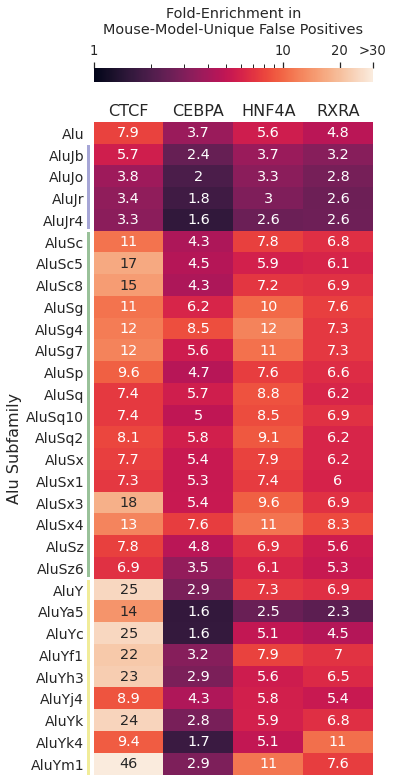

In [106]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib import lines

def plot_subfam_enrichment_heatmap(subfamily_enrichment_df, save = False):

    # re-format the data frame for input into seaborn
    df_to_plot = subfamily_enrichment_df.pivot(index="Alu Subfamily",
                                               columns="TF",
                                               values="Enrichment_mFP")

    # create figure
    fig = plt.figure(figsize=(5, 15))
    sns.set(font_scale = 1.2)
    
    # move axes to correct sides of heatmap
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

    # create heatmap with seaborn
    heatmap = sns.heatmap(df_to_plot, annot=True, 
                norm=LogNorm(vmin=1, vmax=30), vmin=1, vmax=30,
               cbar_kws={"use_gridspec":False, "location":"top"})

    # label colorbar and place tick marks
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks([1, 10, 20, 30])
    cbar.set_ticklabels([1, 10, 20, ">30"])
    cbar.set_label('Fold-Enrichment in\nMouse-Model-Unique False Positives', labelpad = 10.0)

    # change fontsize for subfamily names and TF names
    heatmap.set_yticklabels(heatmap.get_yticklabels(), size = 14)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), size = 16)
    heatmap.xaxis.set_tick_params(length=0)

    heatmap.set(xlabel = None)
    heatmap.set_ylabel(heatmap.get_ylabel(), size = 16)


    # These line positions are hard-coded, not automatically calculated!

    # Alu J line
    ax2 = plt.axes([0.105,0.63,0.55,0.078])
    line = lines.Line2D([0, 0], [0, 1], lw=5., color='darkblue', alpha=0.35)
    ax2.add_line(line)
    ax2.patch.set_visible(False)
    ax2.axis('off')

    # Alu S line
    ax3 = plt.axes([0.105,0.308,0.55,0.32])
    line = lines.Line2D([0, 0], [0, 1], lw=5., color='darkgreen', alpha=0.4)
    ax3.add_line(line)
    ax3.patch.set_visible(False)
    ax3.axis('off')

    # Alu Y line
    ax4 = plt.axes([0.105,0.125,0.55,0.18])
    line = lines.Line2D([0, 0], [0, 1], lw=5., color='#ded000', alpha=0.4)
    ax4.add_line(line)
    ax4.patch.set_visible(False)
    ax4.axis('off')

    if save:
        plt.savefig(ROOT + "plots/alu_subfam_enrichment.png", dpi = 300,
                    bbox_inches='tight', pad_inches = 0)
        plt.savefig(ROOT + "plots/alu_subfam_enrichment.pdf",
                    bbox_inches='tight', pad_inches = 0)
    plt.show()
    

plot_subfam_enrichment_heatmap(subfamily_enrichment_df, save = False)